In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_solution.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()




Train shape: (2000, 65)
Test shape: (500, 56)


,Component1_fraction,Component2_fraction,Component3_fraction,Component4_fraction,Component5_fraction,Component1_Property1,Component2_Property1,Component3_Property1,Component4_Property1,Component5_Property1,...,BlendProperty1,BlendProperty2,BlendProperty3,BlendProperty4,BlendProperty5,BlendProperty6,BlendProperty7,BlendProperty8,BlendProperty9,BlendProperty10
0,0.21,0.00,0.42,0.25,0.12,-0.021782,1.981251,0.020036,0.140315,1.032029,...,0.489143,0.607589,0.321670,-1.236055,1.601132,1.384662,0.305850,0.193460,0.580374,-0.762738
1,0.02,0.33,0.19,0.46,0.00,-0.224339,1.148036,-1.107840,0.149533,-0.354000,...,-1.257481,-1.475283,-0.437385,-1.402911,0.147941,-1.143244,-0.439171,-1.379041,-1.280989,-0.503625
2,0.08,0.08,0.18,0.50,0.16,0.457763,0.242591,-0.922492,0.908213,0.972003,...,1.784349,0.450467,0.622687,1.375614,-0.428790,1.161616,0.601289,0.872950,0.660000,2.024576
3,0.25,0.42,0.00,0.07,0.26,-0.577734,-0.930826,0.815284,0.447514,0.455717,...,-0.066422,0.483730,-1.865442,-0.046295,-0.163820,-0.209693,-1.840566,0.300293,-0.351336,-1.551914
4,0.26,0.16,0.08,0.50,0.00,0.120415,0.666268,-0.626934,2.725357,0.392259,...,-0.118913,-1.172398,0.301785,-1.787407,-0.493361,-0.528049,0.286344,-0.265192,0.430513,0.735073


In [11]:
# Identify columns
blend_features = train.columns[:55]   # 5 + 50 = 55 input features
target_cols = train.columns[-10:]     # last 10 columns are targets

# Split
X = train[blend_features]
y = train[target_cols]


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred)
print("Validation MAPE:", mape)


Validation MAPE: 5.231982549279584


In [20]:
# Drop the ID column if it exists
if 'ID' in test.columns:
    test = test.drop(columns=['ID'])

# Predict
test_pred = model.predict(test)



In [21]:
submission = pd.DataFrame(test_pred, columns=target_cols)
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved successfully!")
submission.head()


✅ submission.csv saved successfully!


,BlendProperty1,BlendProperty2,BlendProperty3,BlendProperty4,BlendProperty5,BlendProperty6,BlendProperty7,BlendProperty8,BlendProperty9,BlendProperty10
0,-0.207154,0.159228,0.384179,-0.013957,-0.295112,-0.012006,0.368759,-0.000649,-0.352771,-0.239687
1,-0.259033,-0.191842,-1.438219,-0.402860,-0.609346,-0.428683,-1.421200,-0.825817,0.187214,-0.141839
2,1.361208,1.126251,1.124025,1.324487,1.503709,1.210042,1.166829,1.545363,0.711720,1.839936
3,0.834092,0.488609,0.700899,0.445551,1.673123,0.236478,0.687288,0.834271,0.369577,-0.241400
4,0.011697,0.184667,1.121491,-0.089804,2.325560,0.282594,1.127257,0.902726,-0.236981,0.797369


In [22]:
from lightgbm import LGBMRegressor

lgb_models = {}
for col in target_cols:
    print(f"Training model for {col}...")
    lgb = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    lgb.fit(X, y[col])
    lgb_models[col] = lgb

# Predictions
preds = np.column_stack([lgb_models[col].predict(test) for col in target_cols])
submission = pd.DataFrame(preds, columns=target_cols)
submission.to_csv("submission_lgb.csv", index=False)


Training model for BlendProperty1...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 55
[LightGBM] [Info] Start training from score -0.016879
Training model for BlendProperty2...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 55
[LightGBM] [Info] Start training from score -0.002076
Training model for BlendProperty3...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[Light

In [23]:
# Evaluate on validation set
val_preds = model.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, val_preds)
print(f"Validation MAPE: {mape:.4f}")


Validation MAPE: 5.2320


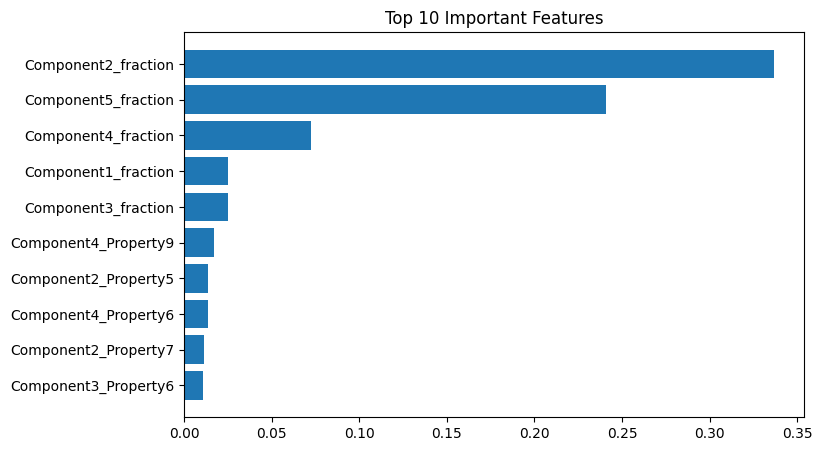

In [24]:
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [blend_features[i] for i in indices])
plt.title("Top 10 Important Features")
plt.show()


In [25]:
# Rule checks
assert submission.shape == (500, 10), "❌ Submission must have 500 rows and 10 columns"
assert all(submission.dtypes == float), "❌ All values must be floating-point numbers"

print("✅ Submission format is correct (500x10, all floats)")


✅ Submission format is correct (500x10, all floats)
